## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd


import sys
sys.path.append('hifigan/')
import numpy as np
import torch
import librosa
import librosa.display
import math
import json
import os
import time

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence, symbol_to_id
from text.cleaners import transliteration_ua_cleaners, english_cleaners, transliteration_cleaners,transliteration_cleaners_with_stress
from text.rudict import RuDict

import torch.nn.utils.prune as prune
from torch.nn import functional as F

from sklearn.metrics.pairwise import cosine_similarity as cs


from hifigan.meldataset import MAX_WAV_VALUE
from hifigan.models import Generator
from hifigan.env import AttrDict

from audio_processing import get_mel

loaded = False



In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')
    plt.savefig('out.png')
    ipd.display(ipd.Image('out.png'))

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050
# hparams.end_symbols_ids = [symbol_to_id[s] for s in '?!.']
# hparams.use_gst = False

In [4]:
checkpoint_path = "outdir/checkpoint_25500"
model = Tacotron2(hparams).cuda()
model.load_state_dict(torch.load(checkpoint_path)['state_dict']) #,map_location=torch.device('cpu')
_ = model.cuda().eval().half()

In [25]:
ref_mel = get_mel('test/test1.wav', hparams).type(torch.HalfTensor).cuda()
print(ref_mel.dtype, ref_mel.shape)

torch.float16 torch.Size([1, 80, 184])


In [26]:
print(ref_mel)

tensor([[[-6.5586, -6.9414, -6.6484,  ..., -5.7969, -4.7070, -3.5684],
         [-6.6914, -6.9883, -6.5039,  ..., -5.3203, -4.1797, -3.1133],
         [-6.5273, -7.0859, -7.3281,  ..., -2.0859, -1.9082, -2.1719],
         ...,
         [-4.7383, -4.3242, -3.8496,  ..., -7.1875, -7.8164, -7.9922],
         [-4.6680, -4.4102, -3.7910,  ..., -7.1836, -7.6211, -8.4766],
         [-4.7852, -4.5273, -4.2148,  ..., -7.7656, -8.1797, -8.6328]]],
       device='cuda:0', dtype=torch.float16)


In [35]:

text = "Тетрагидропиранилциклопентилтетрагидропиридопиридиновые вещества".lower()
text = "Мин+истр здравоохран+ения улет+ел. И обещ+ал верн+уться. С вакц+инами. Нав+ерно, +есть как+ой-то м+ир, где мин+истрам л+ично н+адо лет+ать за вакц+инами с четырьм+я перес+адками во вр+емя эпид+емии. М+ожет по+этому в Зимб+абве уже вакцин+ируют, потом+у чт+о их мин+истр л+ично с+ел на слон+а и по+ехал на нем в больш+ой г+ород преклон+ить кол+ено и получ+ить вакц+ину? Так+ой м+ир нам пыт+аются прод+ать?".lower()
# text = "Вс+е смеш+алось в д+оме Обл+онских. Жен+а узн+ала, что муж был в св+язи с б+ывшею в их д+оме франц+уженкою-гуверн+анткой, и объяв+ила м+ужу, что не м+ожет ж+ить с ним в одн+ом д+оме. Полож+ение это продолж+алось уже третий д+ень и муч+ительно ч+увствовалось и сам+ими супр+угами, и вс+еми чл+енами семь+и, и домоч+адцами."
# text = "Тв+орог или твор+ог, к+озлы или козл+ы, з+амок или зам+ок.".lower()
# text="мн+е хот+елось б+ы? сказ+ать к+ак я призн+ателен вс+ем прис+утсвующим сд+есь."
# text = "tak+oi m+ir n+am pyt+aiutsia prod+at'?"
text = "Как пройти в дом?"
# text = "В+ыйду,,,,,,, н+очью,,, в п+оле,,, с кон+ем"
text = "Н+очь, +улица, фон+арь, апт+ека. Бессм+ысленный, и т+усклый св+ет. Жив+и ещ+е х+оть ч+етверть в+ека - Вс+ё б+удет т+ак. Исх+ода н+ет."
# text = "Ночь, улица, фонарь, аптека. Бессмысленный, и тусклый свет. Жив+и еще хоть четверть века - Все будет так. Исхода нет."
# text = "Игра - тип осмысленной непродуктивной деятельности, где мотив лежит не в её результате, а в самом процессе. Также термин игра используют для обозначения набора предметов или программ, предназначенных для подобной деятельности."
# text = "Прижм+ись к+о мн+е кр+епче и бл+иже. Не ж+ил я,, блужд+ал ср+едь чуж+их. О с+он м+ой,, Я н+овое в+ижу, В бред+у поцел+уев тво+их!"

# text = "Тогд+а почем+у ж+е я ощущ+аю себ+я н+а гр+ани физ+ической катастр+офы?"
# text ="Ты согласен?"
text = "Здр+аствуйте, мен+я зов+ут Андр+ей Никиш+аев, я с+иньер архит+ектор в комп+ании манив+ео. П+о мо+им д+анным у в+ас не закр+ытый кред+ит на с+умму в+осемдесят тр+и т+ысячи тр+иста шестдес+ят тр+и гр+ивны. Н+ужно погас+ить!"
# text = "С к+аждым дн+ем весн+ы стан+овится вс+е тепл+ее, а +это р+адость для к+аждого вод+ителя."
# text = "Молод+ой парн+ишка Т+анг С+ан одн+ажды оступ+ился и сл+едуя сво+им жел+аниям и пр+ихотям вор+ует секр+етные уч+ения в своей школе боевых искусств."

print(transliteration_cleaners_with_stress(text))
sequence = np.array(text_to_sequence(text, ['transliteration_cleaners_with_stress']))[None, :]
print(sequence)
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

Szdr+astvuite, men+ia zov+ut andr+ei nikish+aev, +ia s+in'er arkhit+ektor v komp+anii maniv+eo. p+o mo+im d+annym u v+as ne zakr+ytyi kred+it n+a s+ummu v+osemdesiat tr+i t+ysiachi tr+ista shestdes+iat tr+i gr+ivny. n+uzhno pogas+it'!E
[[12 39 17 31 40 14 32 33 35 34 22 33 18  6 11 26 18 27 40 22 14 11 39 28
  35 40 34 33 11 14 27 17 31 40 18 22 11 27 22 24 22 32 21 40 14 18 35  6
  11 40 22 14 11 32 40 22 27  3 18 31 11 14 31 24 21 22 33 40 18 24 33 28
  31 11 35 11 24 28 26 29 40 14 27 22 22 11 26 14 27 22 35 40 18 28  7 11
  29 40 28 11 26 28 40 22 26 11 17 40 14 27 27 38 26 11 34 11 35 40 14 32
  11 27 18 11 39 14 24 31 40 38 33 38 22 11 24 31 18 17 40 22 33 11 27 40
  14 11 32 40 34 26 26 34 11 35 40 28 32 18 26 17 18 32 22 14 33 11 33 31
  40 22 11 33 40 38 32 22 14 16 21 22 11 33 31 40 22 32 33 14 11 32 21 18
  32 33 17 18 32 40 22 14 33 11 33 31 40 22 11 20 31 40 22 35 27 38  7 11
  27 40 34 39 21 27 28 11 29 28 20 14 32 40 22 33  3  2 13]]


In [36]:
def model_size(model):
    torch.save(model.state_dict(), "temp.p")
    size = ('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')
    return size

In [37]:


# bit8_model = torch.quantization.quantize_dynamic(
#         model, {torch.nn.LSTM, torch.nn.Linear, torch.nn.LSTMCell, torch.nn.GRUCell}, dtype=torch.qint8
# )

# print(model_size(bit8_model))
# for name, module in bit8_model.named_modules():
#     if isinstance(module, torch.nn.Conv1d):
#         prune.l1_unstructured(module, name='weight', amount=0.2)
#     elif isinstance(module, torch.nn.Linear):
#         prune.l1_unstructured(module, name='weight', amount=0.2)
   
# print(model_size(bit8_model))

In [48]:
%%time
# np.random.seed(16)
z_scale = np.ones(32, dtype=np.float32)
z_scale[10] = 2.0

_, mel_outputs, mel_outputs_postnet, _, alignments, emb2 = model.inference(sequence,seed=1234,z_scale=z_scale, reference_mel=ref_mel)

CPU times: user 2 s, sys: 35.8 ms, total: 2.03 s
Wall time: 2.03 s


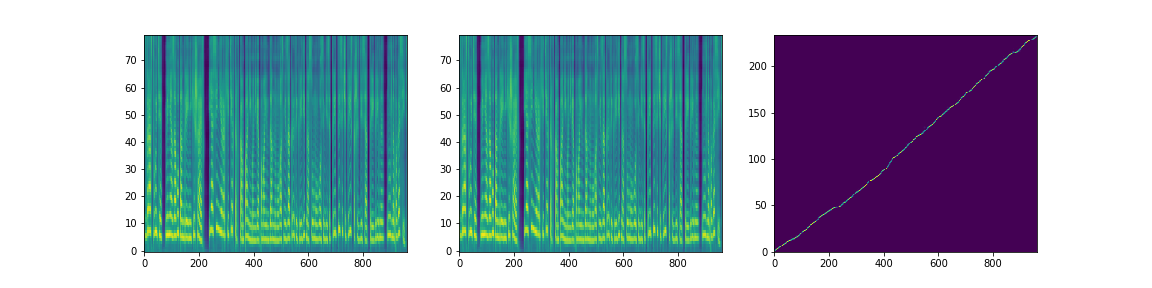

In [49]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [50]:
loaded = False
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

if not loaded:
    device = torch.device('cuda')
    with open('hifigan/config.json') as fp:
        json_config = json.load(fp)
        h = AttrDict(json_config)
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint("hifigan/g_02500000", device)
    generator.load_state_dict(state_dict_g['generator'])
    generator.eval()
    generator.remove_weight_norm()
    
#     generator = torch.quantization.quantize_dynamic(
#         generator, {torch.nn.LSTM, torch.nn.Linear, torch.nn.LSTMCell, torch.nn.GRUCell}, dtype=torch.qint8
#     )
    loaded=True

def inference(mel, generator):
    

    
    with torch.no_grad():
        y_g_hat = generator(mel)
        audio = y_g_hat.squeeze()
        audio = audio * MAX_WAV_VALUE
        audio = audio.detach().cpu().numpy()#.astype('int16')

        return audio
    


Loading 'hifigan/g_02500000'
Complete.
Removing weight norm...


In [51]:
s = time.perf_counter()
mel = mel_outputs_postnet.type(torch.float32)
print(time.perf_counter()-s)
            

0.06524481400265358


In [52]:
%%time
audio = inference(mel, generator)
ipd.Audio(audio, rate=hparams.sampling_rate)  

CPU times: user 225 ms, sys: 4.09 ms, total: 229 ms
Wall time: 228 ms


In [30]:
# style vectors similarity
vect = model.gst.stl.embed

AttributeError: 'NoneType' object has no attribute 'stl'

In [ ]:
norm = F.normalize(vect, dim=1).detach().cpu().numpy()
res =  cs(norm, norm)
res

In [ ]:
(emb1.detach().cpu().numpy()[0][0] - emb2.detach().cpu().numpy()[0][0])

In [ ]:
print(emb1.detach().cpu().numpy().shape)